In [1]:
import collections
import os
import sys
from pathlib import Path

import cv2
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

fontprops = fm.FontProperties(size=34)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = str(Path.cwd().parents[0] / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import my_io as io
from config import *

In [5]:
datasets = sorted([str(f) for f in data_raw.iterdir() if f.is_dir()])
datasets = [name.split("\\")[-1] for name in datasets]
print(datasets)

['DT1', 'DT2', 'DT3', 'DT4', 'DT5', 'DT6', 'NT1', 'NT2', 'NT3', 'NT4', 'NT5', 'NT6']


In [6]:
dataset = datasets[0]

# Read image 

In [7]:
masks, markers = io.read_img(dataset, data_mask)
imgs, _ = io.read_img(dataset, data_raw)

In [8]:
X = masks.reshape(len(imgs), -1)

In [9]:
X = None
markers = []
imgs = []
masks = []

for (dirpath, dirnames, filenames) in os.walk(data_mask / dataset):
    for name in sorted(filenames):
        if "tiff" in name:
            img = cv2.imread(os.path.join(dirpath, name), 0)
            masks.append(img)
            img = img.flatten()
            X = np.concatenate((X, img[None]), axis=0) if X is not None else img[None]

for (dirpath, dirnames, filenames) in os.walk(data_raw / dataset):
    for name in sorted(filenames):
        if "tiff" in name:
            img = cv2.imread(os.path.join(dirpath, name), 0)
            imgs.append(img)
            markers.append(name.split("_")[1].split(".")[0])

C:\Users\thu71\.conda\envs\work\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\thu71\.conda\envs\work\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


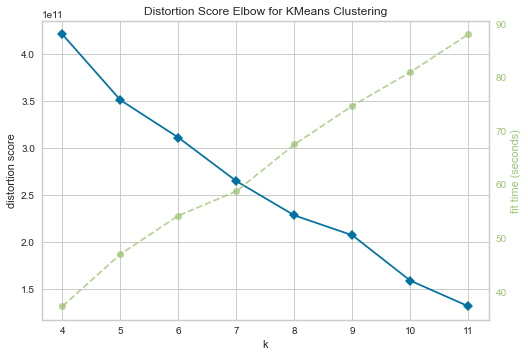

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4, 12))

visualizer.fit(X)  # Fit the data to the visualizer
visualizer.show()

In [11]:
# Clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=2, n_init=15).fit(X / 255)
labels = kmeans.labels_

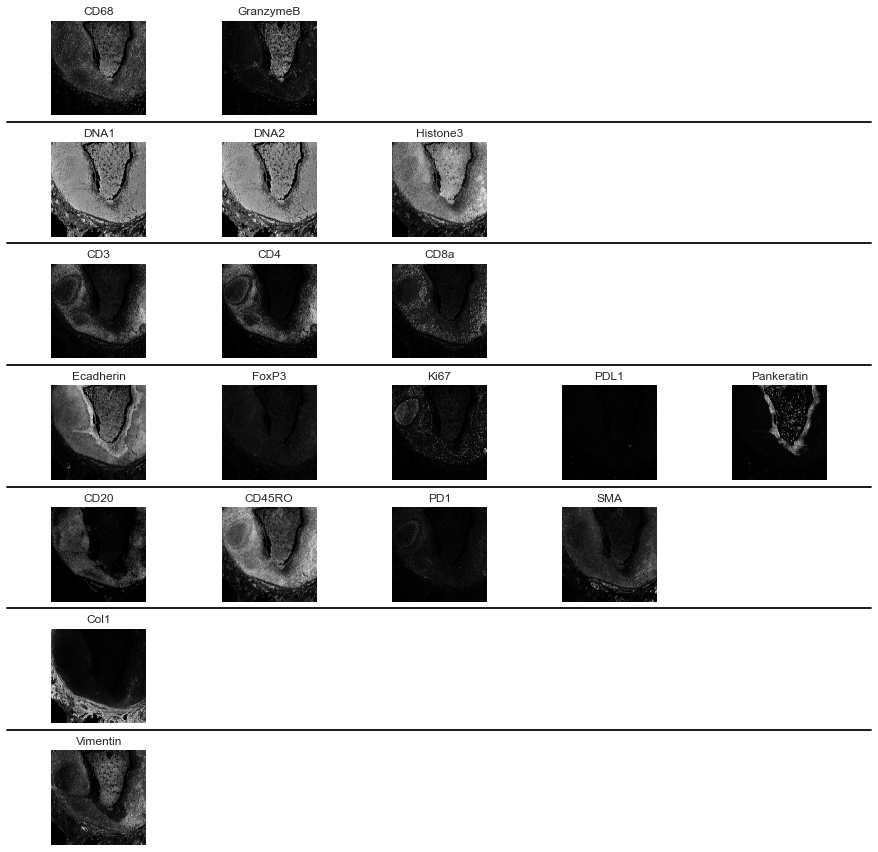

In [12]:
def show_marker_cluster(labels, imgs, markers, path=None):
    count = collections.Counter(labels)
    columns = max(count.values())
    len(count)

    fig, axs = plt.subplots(n_clusters, columns, figsize=(12, 12))
    for i in range(n_clusters):
        j = 0
        for k, label in enumerate(labels):
            if label == i:
                axs[i][j].imshow(imgs[k], cmap="gray")
                axs[i][j].set_title(markers[k])
                axs[i][j].set_ylabel("common ylabel")
                j += 1

    for i in range(n_clusters):
        for j in range(columns):
            axs[i][j].axis("off")

    # rearange the axes for no overlap
    fig.tight_layout()

    # Get the bounding boxes of the axes including text decorations
    r = fig.canvas.get_renderer()
    get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
    bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

    # Get the minimum and maximum extent, get the coordinate half-way between those
    ymax = (
        np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
    )
    ymin = (
        np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
    )
    ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

    # Draw a horizontal lines at those coordinates
    for y in ys:
        line = plt.Line2D([0, 1], [y, y], transform=fig.transFigure, color="black")
        fig.add_artist(line)

    plt.show()

    if path:
        fig.savefig(path, bbox_inches="tight")


show_marker_cluster(labels, imgs, markers)